# Resonance 1 fr and 1/Qi vs T

In [ ]:
# Example usage
# from iminuit.cost import LeastSquares
# from IRdetection.src.analysis.FitAPI import Fitter, Model
# import numpy as np
import numpy as np
import sys
# sys.path.append('../Graphics')
# from Graphs import fitPlotter
# import matplotlib.pyplot as plt
# import models as md

def S21_model(f: np.ndarray, f0: float, phi: float, Qt: float, Qc: float, A: float, B: float, C: float, D: float, K: float, fmin: float) -> np.ndarray:
    return (A+B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - (Qt/np.abs(Qc))*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))

def resonance_model(f: np.ndarray, f0: float, phi: float, Qt: float, Qc: float, A: float, B: float, C: float, D: float, K: float, fmin: float) -> np.ndarray:
    return (A+B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - (Qt/np.abs(Qc))*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))

# Estimate the initial guess of Qt
def peak_width(datax, datay):
    half_height_value = np.min(datay) + (np.max(datay) - np.min(datay)) / np.sqrt(2)
    hits = []
    above = datay[0] > half_height_value
    for i in range(1, len(datay)):
        new_above = datay[i] > half_height_value
        if new_above != above: 
            hits.append((datax[i] + datax[i-1]) / 2)
            above = new_above
    return abs(hits[-1] - hits[0])

result_fr = []
err_fr = []
result_Qi = []
err_Qi = []
T = []

f = []
y = []
for i in range(40, 116, 2):
    path = '../Data/fit_test/gap run12/Q_res' +str(i) +'.txt'
    data = np.loadtxt(path, delimiter=',', skiprows=0)
    f.append(data[:,0])
    I = data[:,1]
    Q = data[:,2]
    # Convert to module
    y.append(np.sqrt(I**2 + Q**2))
    T.append(410 - 10*((i-40)/2))

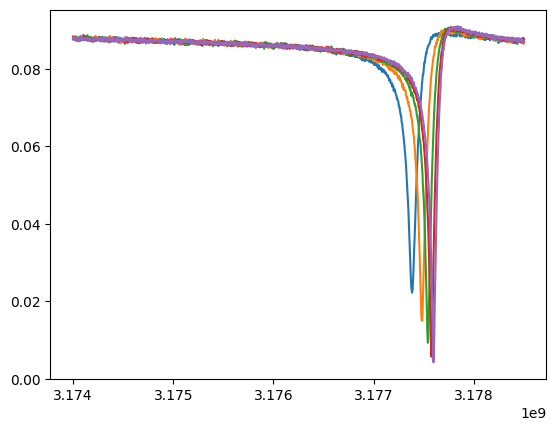

In [2]:
for i in range(5):
    plt.plot(f[i*3], y[i*3])
plt.show()

In [8]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import numpy as np
from scipy import stats
from typing import Callable, Optional
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import irdetection.analysis.fitting.models as md
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font
from irdetection.graphics.plots import plot
from irdetection.graphics.palettes import QSciencePalette, QScienceTypography

In [9]:
class Model:
    def __init__(self, model_function: Callable, param_names: list[str]):
        self.model_function = model_function
        self.param_names = param_names
        for name in param_names:
            setattr(self, name, None)
    
    def assing_params(self, params: dict[str, float]) -> None:
        for p_name in self.param_names:
            setattr(self, p_name, params[p_name])
    
    def set_active_params(self, active_params: list[str]) -> None:
        self.active_params = {}
        # check if the active params are valid
        for p_name in active_params:
            if p_name not in self.param_names:
                raise ValueError(f"{p_name} is not a valid parameter name")
        
        for p_name in self.param_names:
            if p_name in active_params:
                self.active_params[p_name] = True
            else:
                self.active_params[p_name] = False
                
    def set_fixed_params(self, fixed_params: list[str]) -> None:
        self.active_params = {}
        # check if the active params are valid
        for p_name in fixed_params:
            if p_name not in self.param_names:
                raise ValueError(f"{p_name} is not a valid parameter name")
            
        for p_name in self.param_names:
            if p_name in fixed_params:
                self.active_params[p_name] = False
            else:
                self.active_params[p_name] = True
                
        
    def __call__(self, data, *args) -> np.ndarray:
        # create the active model function. i.e. model function with only the active parameters
        param_dict = {}
        param_iter = iter(args)
        for p_name in self.param_names:
            if self.active_params.get(p_name):  # if the parameter is active
                param_dict[p_name] = next(param_iter)
            else:  # if the parameter is not active
                param_dict[p_name] = getattr(self, p_name)
        return self.model_function(data, **param_dict)

class Fitter:
    def __init__(self, 
                 model_function: Callable, 
                 param_names: list[str], 
                 data: np.ndarray,
                 loss_function: Callable,
                 yerr: Optional[np.ndarray] = None, 
                 xerr: Optional[np.ndarray] = None, 
                 params_initial_guess: Optional[dict[str, float]] = None, 
                 params_range: Optional[dict[str, tuple[float, float]]] = None):
        # Check if the data is valid
        if not 0 < len(data[0]) < 3:
            raise ValueError("Data must be 1D or 2D")
        if len(data[0]) == 1:
            raise NotImplementedError("1D data is not supported yet")
        
        self.x = data[:, 0]
        self.y = data[:, 1]
        self.yerr = yerr
        self.xerr = xerr
        # Define the model
        self.model = Model(model_function, param_names)
        # Assign the initial guess to the model if provided
        if params_initial_guess is not None:
            self.model.assing_params(params_initial_guess)
        
        self.loss_function = loss_function  
        self.params_range = params_range
    
    def fit_quasi_magicus(self, N_fixed_params: Optional[int] = None, pvalue_treshold: Optional[float] = 0.005, try_total_fit_first: Optional[bool] = True):
        """
        Fit the data using quasi-magicus method
        
        NOTE: It's Leviosa not Leviosar
        """
        # Fit the model with all the parameters 
        if try_total_fit_first:
            self.model.set_active_params(self.model.param_names)
            fit_result = self.fit()
            if fit_result.valid:
                if p_value(fit_result) > pvalue_treshold:
                    print(f"First total fit converged good, p-value = {p_value(fit_result)}")
                    return fit_result
                else:
                    print(f"First total fit converged bad, p-value = {p_value(fit_result)}")
            else:
                print("First total fit failed")
        
        if N_fixed_params is None:
            N_fixed_params = len(self.model.param_names)//2 #default fixed params is half of the total params
        
        params_to_fit = self.model.param_names
        #partial fit
        iter_counter = 0
        while len(params_to_fit) > 0:
            print(f"Partial fit {iter_counter}")
            # Set the fixed params
            N_fixed_params = min(N_fixed_params, len(params_to_fit))
            self.model.set_fixed_params(self.model.param_names[:N_fixed_params])
            # Fit the model with the fixed params
            fit_result = self.fit()
            # Check if the fit converged
            if fit_result.valid:
                # Check if the p-value is greater than the treshold
                if p_value(fit_result) > pvalue_treshold: # Fit is good
                    # pop first N_fixed_params
                    params_to_fit = params_to_fit[N_fixed_params:]
                    # Set inital guess of currently active params to the fitted values
                    result_values = fit_result.values.to_dict()
                    self.model.assing_params({p_name: result_values[p_name] for p_name in result_values})
                    print(f"Partial fit {iter_counter} converged good , p-value = {p_value(fit_result)}")
                else: # Fit is bad
                    # put first element at the end
                    params_to_fit = params_to_fit[1:] + [params_to_fit[0]]  
                    print(f"Partial fit {iter_counter} converged bad , p-value = {p_value(fit_result)}")          
            else:
                # put first element at the end
                params_to_fit = params_to_fit[1:] + [params_to_fit[0]]
                print(f"Partial fit {iter_counter} did not converge")
            
            # Check if all partial fits failed
            if iter_counter == len(self.model.param_names):
                raise RuntimeError("The fit did not converge. All partial fits failed")
            iter_counter += 1
        
        # Final fit with all params
        self.model.set_active_params(self.model.param_names)
        return self.fit()
    
    def fit_non_magicus(self):
        self.model.set_active_params(self.model.param_names)
        return self.fit()
        
    def fit(self):
        active_params_names = [p_name for p_name, is_active in self.model.active_params.items() if is_active]
        active_params = {p_name: getattr(self.model, p_name) for p_name in active_params_names}

        if self.yerr is None: # Estimate the error as 1% of the data if greater than 1e-5 else 1e-5
            self.yerr = np.maximum(1e-5, 0.01 * self.y)
        if self.xerr is None:
            loss = self.loss_function(self.x, self.y, self.yerr, self.model, name=active_params_names)
        else:
            loss = self.loss_function(self.x, self.y, self.xerr, self.yerr, self.model, name=active_params_names)
        
        m = Minuit(loss, **active_params)

        #set params limits
        if self.params_range is not None:
            for p_name, p_range in self.params_range.items():
                m.limits[p_name] = p_range

                
        m.migrad()
        return m

def p_value(m: Minuit) -> float:
    return 1 - stats.chi2.cdf(m.fval, m.ndof)

[3177396015.351663, 3177425738.5037513, 3177465297.0910215, 3177493053.0695925, 3177517248.32517, 3177535860.681607, 3177553122.2665167, 3177567739.1779194, 3177578963.2513194, 3177589919.720995, 3177598675.1238155, 3177605847.9823704, 3177611186.360307, 3177616313.265605, 3177620591.6524982, 3177624106.122768, 3177626089.335225, 3177627385.633903, 3177631000.0883985, 3177633128.9480386, 3177634018.9025903, 3177636238.772669, 3177637187.201853, 3177638255.5443068, 3177639203.7727447, 3177640163.3014703, 3177639620.8188143, 3177641600.765922, 3177640866.3242507, 3177640965.9520473, 3177641945.1608095, 3177642480.976211, 3177642479.149627, 3177641914.9819055, 3177642234.4250526, 3177641795.6004395, 3177641852.895592, 3177641979.5751214]
[148786.462193046, 183311.2626402833, 212648.9744890921, 229182.87752435898, 292861.7335529007, 422895.1823094376, 457235.6474152519, 628850.4756221201, 565278.9137395191, 1221498.8860499177, 1881394.2734976034, 1011811.5628322792, 1809404.8709190127, 302

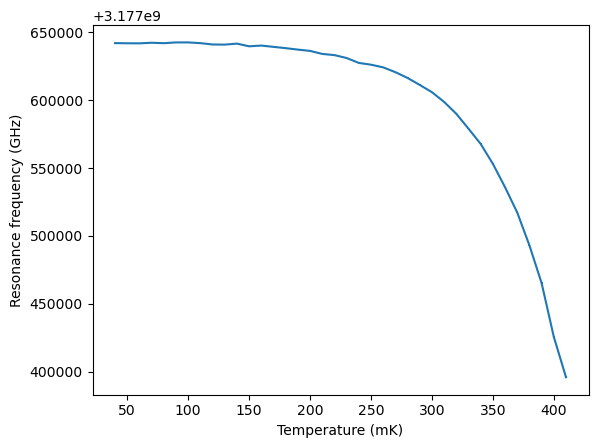

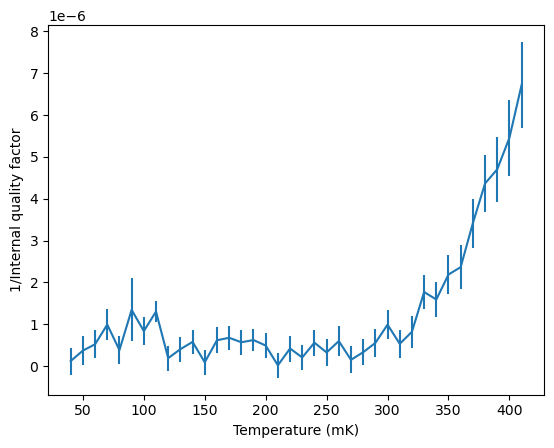

In [10]:
#empty result and err arrays
result_fr = []
err_fr = []
result_Qi = []
err_Qi = []

initial_guess = {
    "f0": 17000, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    }

param_limits = {
    "Qc": (1e2, 1e7),
    "Qt": (1e2, 1e7),
    #'phi': (-20, 20),
    #'f0': (-1e6, 1e6),
    }

for i in range(0, len(T)):
    f_i = f[int(i)]
    y_i = y[int(i)]
    
    fmin = f_i[np.argmin(y_i)]
    initial_guess['fmin'] = fmin
    fwhm = peak_width(f_i, -y_i)
    
    mask = (f_i > fmin - 7 * fwhm) & (f_i < fmin + 7 * fwhm)
    f_i = f_i[mask]
    y_i = y_i[mask]

    # Estimate the initial guess of Qt
    Qt_guess = fmin / peak_width(f_i, -y_i)
    initial_guess['Qt'] = Qt_guess

    # Estimate the initial guess of K
    initial_guess['K'] = (np.max(y_i) - np.min(y_i)) * initial_guess['Qc'] / initial_guess['Qt']
    #print(f"Initial guess: {initial_guess}")

    fit_data = np.column_stack((f_i, y_i))
    fitter = Fitter(model_function=S21_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                    data=fit_data, 
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess,
                    params_range=param_limits)

    fitter.model.set_fixed_params({"fmin": fmin})
    result = fitter.fit()
    result_dict = result.values.to_dict()
    err_dict = result.errors.to_dict()
    
    result_fr.append(result_dict['f0'] + fmin)
    err_fr.append(err_dict['f0'])
    
    result_Qi.append(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1))
    Qt = result_dict['Qt']
    Qc = result_dict['Qc']
    err_Qi.append(np.sqrt((err_dict['Qt'] * Qt**-2)**2 + (err_dict['Qc'] * Qc**-2)**2) * ((1/Qt-1/Qc)**-2))
    
    #print("Q_res" + str(i*2 + 40))
    #print("Q_i: " + str(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1)))
    
    #print(f"Result: {result_dict}")
    # grapher = fitPlotter(result, f_i, y_i, md.resonance_model)
    # grapher.simple_plot()
    
    
    
print(result_fr)
print(result_Qi)
print(T) 

plt.errorbar(T, result_fr, err_fr, linestyle='-', label='fr')
plt.ylabel('Resonance frequency (GHz)')
plt.xlabel('Temperature (mK)')
plt.show()

Qi_plot = 1/np.array(result_Qi)
err_Qi_plot = err_Qi*np.array(result_Qi)**-2

plt.errorbar(T, Qi_plot, err_Qi_plot, linestyle='-', label='Qi')
plt.ylabel('1/Internal quality factor')
plt.xlabel('Temperature (mK)')
plt.show()

Result: {'D0_k': 3.7134829208989393, 'w': 3177641828.709725, 'Q0': 1860567.0843990843, 'a': 0.8}
Result D0 (meV): 0.3204385300785125 +- 0.0023893285157168443
T_C (K): 2.1099334777834886 +- 0.015732578174973207


(<Figure size 1000x800 with 2 Axes>,
 (<Axes: title={'center': 'Inverse of Internal Quality Factor as a function of temperature'}, ylabel='$1/Q_i$'>,
  <Axes: xlabel='Temperature (mK)', ylabel='Residuals'>))

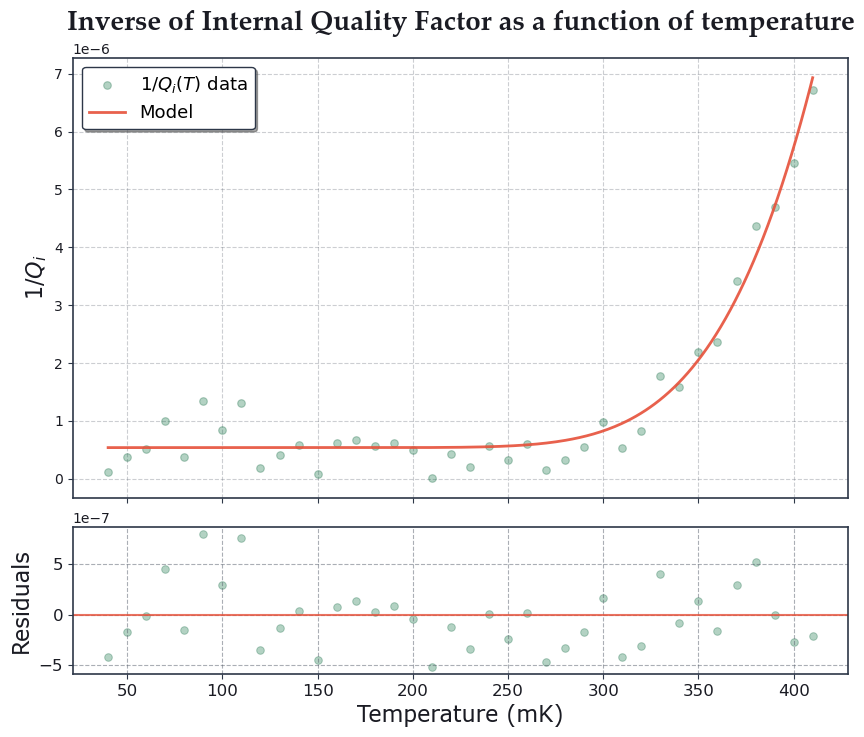

In [13]:
from scipy import constants as cs
mask = (np.array(T)<250.0)
mask2= (np.array(T)<150)
_Q0 = np.mean(np.array(Qi_plot)[mask])
w = np.mean(np.array(result_fr)[mask2])

initial_guess = {
    "Q0": _Q0**-1,
    "a": 0.8,
    "D0_k": 3.67,
    "w": w
    }

fit_data = np.column_stack((T, Qi_plot))
fitter = Fitter(model_function=md.qi_factor_model, 
                    param_names=["Q0", "a", "D0_k", "w"], 
                    data=fit_data, 
                    yerr=err_Qi_plot,
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess)

fitter.model.set_active_params(["D0_k"])
result = fitter.fit()

result_dict = result.values.to_dict()
result_dict['w'] = w
result_dict['Q0'] = _Q0**-1
result_dict['a'] = initial_guess['a']
err_dict = result.errors.to_dict()

print(f"Result: {result_dict}")
print(f"Result D0 (meV): {result_dict["D0_k"]*cs.k/(1.6e-22)} +- {err_dict['D0_k']*cs.k/(1.6e-22)}")
T_C = 2/3.52 * result_dict["D0_k"]
print(f"T_C (K): {T_C} +- {2/3.52 * err_dict['D0_k']}")

# grapher = fitPlotter(result_dict, T, Qi_plot, md.qi_factor_model, err_y = err_Qi_plot)
# grapher.simple_plot()

plot_fit(
    data=fit_data,
    model=md.qi_factor_model,
    model_params=result_dict,
    title=r'Inverse of Internal Quality Factor as a function of temperature',
    xlabel=r'Temperature (mK)',
    ylabel=r'$1/Q_i$',  # mathtext will still render this correctly
    data_label=r'$1/Q_i(T)$ data',
    # model_label=(
    #     r'Fit: $\frac{1}{2}\left[\frac{I^2}{%.2f^2} + \frac{I^4}{%.2f^4}\right]$'
    #     % (fitted_params["a"], fitted_params["b"])
    #),
    palette=QSciencePalette,
    typography=QScienceTypography,
    rasterize_points=True,
)